# Test amplitude optimization component of matched filter

In [31]:
from GW_class import *
from template import waveform
import constants as c
import numpy as np

## Simulate data

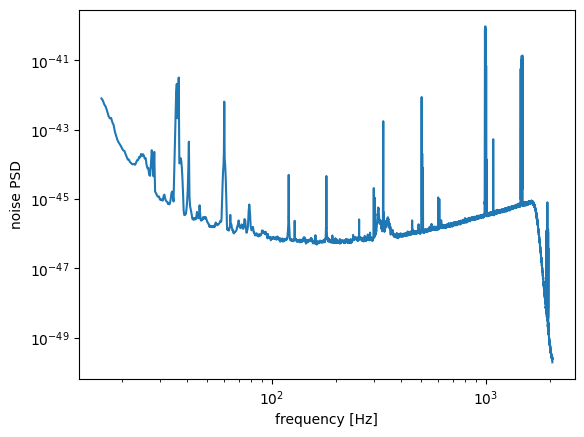

In [32]:
# get GW150914 estimated PSD
psd_func = GW150914.dictionary['large_data_psds']['H1']
psd = psd_func(c.freqs)
plt.loglog(c.freqs_for_waveform, psd_func(c.freqs_for_waveform))
plt.xlabel('frequency [Hz]')
plt.ylabel('noise PSD')
plt.show()

In [33]:
# # choose some component parameters
# comp_params = np.array([35.6, 30.6, -0.01, 0.0])

# # make template in frequency-domain
# template_FD = waveform.get_FD_waveform(comp_params, 0.)

# # data is template multiplied by some "unknown" amplitude
# random_amp = 5.3
# data_FD = random_amp * template_FD

# # phase shift to make things interesting
# random_phase = np.pi / 5.
# data_FD *= np.exp(-1.j * random_phase)

# # time shift to make things interesting
# time_shift = waveform.times_full[int(1e4)]
# data_FD *= np.exp(-2. * np.pi * 1.j * c.freqs * time_shift)

# # whiten data and transform to time-domain
# data_FD_whitened = data_FD / np.sqrt(psd_func(c.freqs))
# data_TD = np.fft.irfft(data_FD, waveform.times_full.shape[0])
# data_TD_whitened = np.fft.irfft(data_FD_whitened, waveform.times_full.shape[0])

# plot data
# plt.plot(waveform.times_full, data_TD_whitened)
# plt.xlabel('time [s]')
# plt.ylabel('fake whitened data')
# plt.show()

In [34]:

# import GW150914 dictionary
time = GW150914_data['time']
time_center = GW150914_data['time_center']
dt = GW150914_data['dt']
fs = GW150914_data['fs']
large_data_psds = GW150914_data['large_data_psds']


# amount of data we want to calculate matched filter SNR over- up to 32s
data_time_window = time[len(time) - 1] - time[0] - (32 - 4)

time_filter_window = np.where((time <= time_center + data_time_window * .5) & 
                              (time >= time_center - data_time_window * .5))

In [35]:
comp_params = (signal_ref_params['GW150914'][1])

# compute template for GW150914 
template_FD = get_template(signal_ref_params['GW150914'][1], GW150914.dictionary)

#initialize detector 
det = 'H1'
# keeping here just we need it
strain = GW150914_data[det]['strain'][time_filter_window]
strain_whiten = GW150914_data[det]['strain_whiten'][time_filter_window]
strain_whitenbp = GW150914_data[det]['strain_whitenbp'][time_filter_window]
data_psd = large_data_psds[det]


# compute data for GW150914

data_TD_whitened = GW150914_data[det]['strain_whiten'][time_filter_window]
#data_FD= np.fft.rfft(strain)
#data_FD_whitened = data_FD / np.sqrt(psd_func(c.freqs))
data_TD = strain



## Matched filter functions

In [36]:
# spacing between frequency bins
df = c.freqs[1] - c.freqs[0]


In [37]:
# noise weighted inner product
def inner(a, b):  # (a, b) are signals in frequency-domain
  
    integrand = np.real(a * b.conjugate()) / psd
   
    return 4 * np.sum(integrand) * df

In [38]:
# normalize template

p_normalization_factor = np.sqrt(inner(template_FD, template_FD))

p = template_FD / p_normalization_factor

print(inner(p, p))


0.9999999999999998


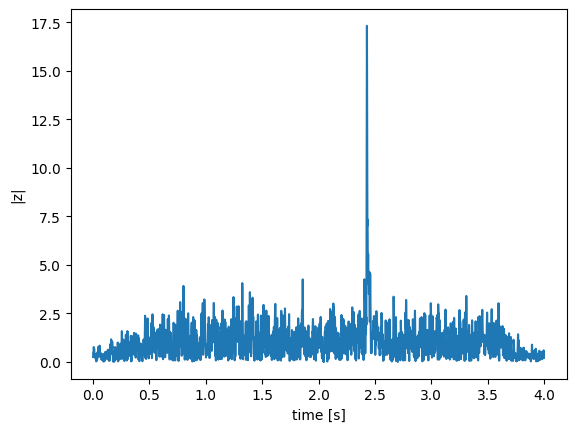

In [51]:
# time shifts to search over for optimization
time_shifts = waveform.times_full - waveform.times_full[0]
from scipy.signal.windows import tukey


# complex SNR time series
def get_SNR_time_series(template_FD, data_TD):

    dwindow= tukey(data_TD.size, alpha= 1./4)
    
    data_FD = np.fft.rfft(data_TD*dwindow) * dt
    
    # time shifts in frequency-domain (complex phase)
    time_shift_in_FD = np.exp(2. * np.pi * 1.j * c.freqs[:, None] * time_shifts[None, :])
    integrand = (data_FD * template_FD.conjugate() / psd)[:, None] * time_shift_in_FD
    
    # do Fourier transform manually
    z = 4. * np.sum(integrand, axis=0) * df 

    return z


# plot complex SNR time series
z = get_SNR_time_series(p, data_TD)

# possible time shifts to minimize chi-squared
plt.plot(time_shifts, np.abs(z))
plt.xlabel('time [s]')
plt.ylabel('|z|')
plt.show()

2.429103347877052


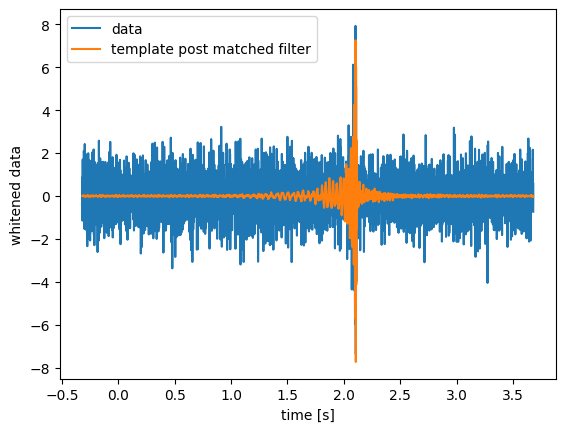

In [52]:
# get optimal time-shift, phase, and amplitude
opt_ndx = np.argmax(np.abs(z))
opt_time_shift = time_shifts[opt_ndx]
opt_amplitude = np.abs(z)[opt_ndx]
opt_phase = np.angle(z[opt_ndx])

print(opt_time_shift)

# optimal template in frequency-domain
# scale by optimal frequency
opt_template_FD = opt_amplitude * p
# optimal time shift
opt_template_FD *= np.exp(-2. * np.pi * 1.j * c.freqs * opt_time_shift)
# add phase shift
opt_template_FD *= np.exp(1.j * opt_phase)

# whiten template
opt_template_FD_whitened = opt_template_FD / np.sqrt(psd)

dwindow= tukey(data_TD.size, alpha= 1./4)
data_FD = np.fft.rfft(data_TD*dwindow) 
fband = [35.0, 350.0]
mask = np.logical_and(np.abs(c.freqs) >= fband[0] , (np.abs(c.freqs) <= fband[1]))
data_FD *= mask
data_FD_whitened = data_FD/ np.sqrt(psd)
whitened_data_TD= np.fft.irfft(data_FD_whitened, waveform.times_full.shape[0])


#plt.plot((np.fft.irfft(data_FD_whitened, waveform.times_full.shape[0])/strain_whitenbp)**-1)
#plt.ylim(0,10)

# optimal template in time-domain (whitened)
# need normalization constants?
opt_template_TD = np.fft.irfft(opt_template_FD_whitened, waveform.times_full.shape[0]) *4*np.sqrt(fs)
plt.plot(waveform.times_full, strain_whitenbp, label='data', color='C0')
#plt.plot(waveform.times_full, whitened_data_TD, label = 'TD 2', color = 'green')
#plt.plot(waveform.times_full, np.fft.irfft(template_FD / np.sqrt(psd), len(waveform.times_full)),
         #label='template before matched filter', color='C3')
plt.plot(waveform.times_full, opt_template_TD, label='template post matched filter',color='C1')
#plt.plot(waveform.times_full, data_TD, label = 'unwhitened data', color = 'green')
plt.xlabel('time [s]')
#plt.xlim(1.6,2.2)
plt.ylabel('whitened data')
plt.legend()
plt.show()

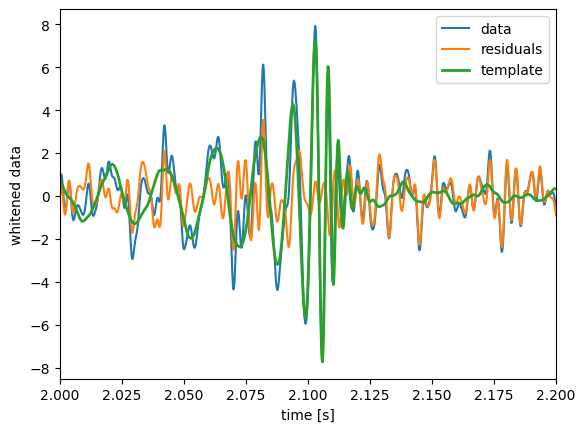

In [53]:
# zoom-in!
plt.plot(waveform.times_full, strain_whitenbp, label='data')
#plt.plot(waveform.times_full, strain_whitenbp - opt_template_TD, label = 'residuals')
plt.plot(waveform.times_full, opt_template_TD, label='template', lw=2)
plt.xlabel('time [s]')
plt.ylabel('whitened data')
plt.legend()
plt.xlim(2.0, 2.2)
plt.show()